In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from PIL import Image, UnidentifiedImageError

root_folder = "./images"

labels = []
file_paths = []


for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)
            
            try:
                with Image.open(file_path) as img:
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError): # 깨진파일
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)
df = pd.DataFrame({"label": labels, "path": file_paths})

print(df)

       label                            path
0      고로쇠나무  ./images\고로쇠나무\12226_고로쇠나무.jpg
1      고로쇠나무  ./images\고로쇠나무\12227_고로쇠나무.jpg
2      고로쇠나무  ./images\고로쇠나무\12228_고로쇠나무.jpg
3      고로쇠나무  ./images\고로쇠나무\12229_고로쇠나무.jpg
4      고로쇠나무  ./images\고로쇠나무\12230_고로쇠나무.jpg
...      ...                             ...
37769   황칠나무    ./images\황칠나무\53360_황칠나무.jpg
37770   황칠나무    ./images\황칠나무\53361_황칠나무.jpg
37771   황칠나무    ./images\황칠나무\53362_황칠나무.jpg
37772   황칠나무    ./images\황칠나무\53363_황칠나무.jpg
37773   황칠나무    ./images\황칠나무\53364_황칠나무.jpg

[37774 rows x 2 columns]


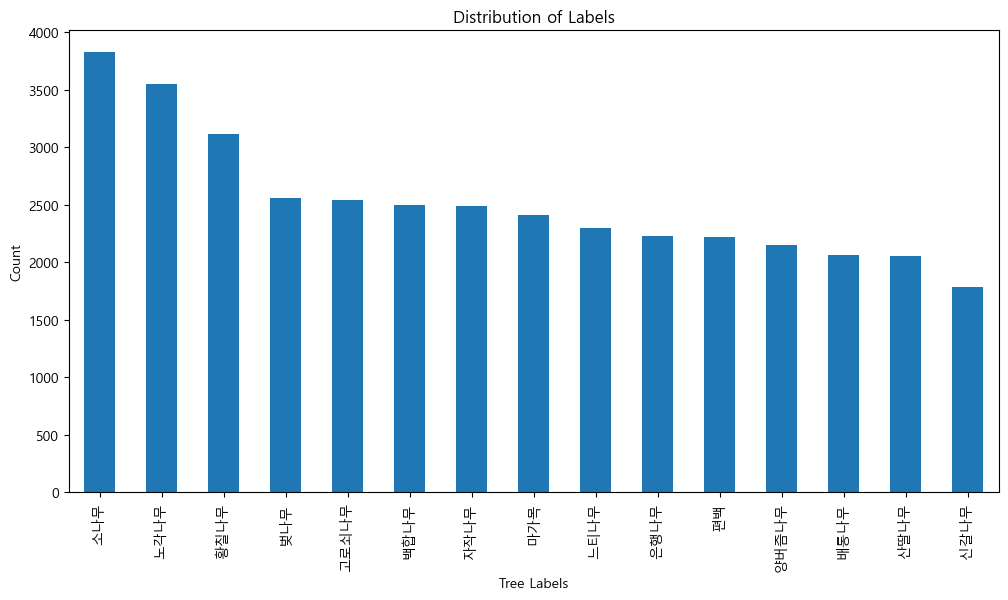

In [3]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

label_counts = df['label'].value_counts()

plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [4]:
print(df['label'].unique())
print(len(df['label'].unique()))

['고로쇠나무' '노각나무' '느티나무' '마가목' '배롱나무' '백합나무' '벚나무' '산딸나무' '소나무' '신갈나무'
 '양버즘나무' '은행나무' '자작나무' '편백' '황칠나무']
15


In [5]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")
print(f"Validation set: {len(valid)} samples")

Train set: 26441 samples
Test set: 5666 samples
Validation set: 5667 samples


In [6]:
train

,path,label_encoded
9820,./images\마가목\8937_마가목.jpg,3
29604,./images\은행나무\21364_은행나무.jpg,11
1041,./images\고로쇠나무\13270_고로쇠나무.jpg,0
7803,./images\느티나무\11713_느티나무.jpg,2
16333,./images\벚나무\1876_벚나무.jpg,6
...,...,...
24657,./images\신갈나무\22993_신갈나무.jpg,9
28451,./images\은행나무\20209_은행나무.jpg,11
33775,./images\편백\16103_편백.jpg,13
21140,./images\소나무\58679_소나무.jpg,8


In [7]:
decoded_predictions = label_encoder.inverse_transform([8, 0, 2])

In [8]:
decoded_predictions

array(['소나무', '고로쇠나무', '느티나무'], dtype=object)

In [9]:
df

,label,path,label_encoded
0,고로쇠나무,./images\고로쇠나무\12226_고로쇠나무.jpg,0
1,고로쇠나무,./images\고로쇠나무\12227_고로쇠나무.jpg,0
2,고로쇠나무,./images\고로쇠나무\12228_고로쇠나무.jpg,0
3,고로쇠나무,./images\고로쇠나무\12229_고로쇠나무.jpg,0
4,고로쇠나무,./images\고로쇠나무\12230_고로쇠나무.jpg,0
...,...,...,...
37769,황칠나무,./images\황칠나무\53360_황칠나무.jpg,14
37770,황칠나무,./images\황칠나무\53361_황칠나무.jpg,14
37771,황칠나무,./images\황칠나무\53362_황칠나무.jpg,14
37772,황칠나무,./images\황칠나무\53363_황칠나무.jpg,14


In [10]:
import cv2

BATCH_SIZE = 32

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)
        
        return image, label


transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

train_dataset = TreeDataset(dataframe=train, transform=transform)
test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

26441
5666
5667


In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

827
178
178


In [12]:
train

,path,label_encoded
9820,./images\마가목\8937_마가목.jpg,3
29604,./images\은행나무\21364_은행나무.jpg,11
1041,./images\고로쇠나무\13270_고로쇠나무.jpg,0
7803,./images\느티나무\11713_느티나무.jpg,2
16333,./images\벚나무\1876_벚나무.jpg,6
...,...,...
24657,./images\신갈나무\22993_신갈나무.jpg,9
28451,./images\은행나무\20209_은행나무.jpg,11
33775,./images\편백\16103_편백.jpg,13
21140,./images\소나무\58679_소나무.jpg,8


In [13]:
train_dataset[0][0]

tensor([[[-0.4226, -0.9534, -0.9534,  ...,  1.7523,  1.5639,  1.2043],
         [-0.6452, -0.8849, -0.8507,  ...,  1.7352,  1.7180,  1.6153],
         [-0.3883, -0.6281, -0.8335,  ...,  1.8550,  1.9920,  1.8550],
         ...,
         [ 1.5468,  1.5639,  1.6838,  ...,  0.7591,  0.9646,  1.0673],
         [ 1.7009,  1.6495,  1.6153,  ...,  1.2043,  1.5125,  1.6324],
         [ 1.5639,  1.5982,  1.6153,  ...,  1.7694,  1.9407,  2.0092]],

        [[-0.4951, -1.0728, -1.0728,  ...,  1.9384,  1.7458,  1.3782],
         [-0.7227, -1.0028, -0.9678,  ...,  1.9384,  1.9034,  1.7983],
         [-0.4601, -0.7402, -0.9853,  ...,  2.0609,  2.1835,  2.0434],
         ...,
         [ 1.4657,  1.4657,  1.5532,  ..., -0.3901, -0.1275, -0.0049],
         [ 1.6758,  1.5532,  1.5007,  ...,  0.0476,  0.3803,  0.5028],
         [ 1.6057,  1.5532,  1.5182,  ...,  0.6429,  0.8880,  1.0455]],

        [[-0.6193, -1.1073, -1.0898,  ...,  2.1868,  1.9951,  1.6640],
         [-0.8284, -1.0550, -1.0027,  ...,  2

In [14]:
train_dataset[5][0].shape

torch.Size([3, 224, 224])

In [15]:
train_dataset[3][1]

tensor(2)

In [16]:
train_dataset[5]

(tensor([[[ 0.3823,  1.2385,  1.0502,  ...,  0.2111,  0.3994,  0.5364],
          [ 0.3309,  1.1529,  1.2043,  ...,  0.4337,  0.5193,  0.5536],
          [-0.2513,  0.6392,  0.9646,  ...,  0.6221,  0.6392,  0.6221],
          ...,
          [-0.1314,  0.0912, -1.2617,  ...,  0.6049,  0.5536,  0.5364],
          [-0.7308, -0.2342, -1.4672,  ...,  0.5022,  0.6049,  0.5707],
          [-1.1247, -1.1760, -1.6898,  ...,  0.5022,  0.7077,  0.6049]],
 
         [[ 1.1506,  1.8683,  1.7983,  ...,  0.0826,  0.2927,  0.4678],
          [ 1.1681,  1.8683,  1.8859,  ...,  0.3102,  0.4328,  0.4678],
          [ 0.6604,  1.4132,  1.7283,  ...,  0.5378,  0.5728,  0.5728],
          ...,
          [-0.2325,  0.0476, -1.2654,  ...,  0.4328,  0.5378,  0.4503],
          [-0.8803, -0.3375, -1.4755,  ...,  0.3102,  0.5553,  0.4503],
          [-1.1954, -1.2129, -1.6681,  ...,  0.2402,  0.5728,  0.4678]],
 
         [[ 0.3742,  1.1759,  1.0888,  ..., -0.1835, -0.0267,  0.0779],
          [ 0.2522,  1.1062,

In [17]:
next(iter(train_loader))

[tensor([[[[-1.1075, -1.0904, -1.4158,  ..., -0.5596,  0.0569,  0.5878],
           [-0.7308, -0.3369, -0.7137,  ..., -0.5253, -0.5253,  0.2624],
           [-0.3883, -0.6452, -0.5424,  ...,  0.1768, -0.2684,  0.5536],
           ...,
           [ 0.1768,  0.5364,  0.1939,  ...,  0.5364,  0.0569,  0.4508],
           [ 0.6906,  1.1015,  0.5878,  ...,  0.7419,  0.0227, -0.7308],
           [ 0.8789,  1.1700,  0.0741,  ...,  0.7419,  0.6221, -0.2856]],
 
          [[-0.5126, -0.5126, -0.9153,  ..., -0.7052, -0.2150,  0.2927],
           [ 0.0301,  0.5728,  0.0301,  ..., -0.6352, -0.6877,  0.0126],
           [ 0.4503,  0.2402,  0.3803,  ..., -0.0399, -0.4426,  0.2752],
           ...,
           [ 0.4678,  0.8179,  0.6078,  ...,  0.0826, -0.3025,  0.0826],
           [ 1.1155,  1.5532,  1.2556,  ...,  0.2752, -0.3550, -1.0203],
           [ 1.3081,  1.6758,  0.7304,  ...,  0.2752,  0.2577, -0.5126]],
 
          [[-1.1421, -1.1421, -1.3164,  ..., -0.4798,  0.0082,  0.2173],
           [-

In [18]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [19]:
train_dataset[0][1]

tensor(3)

In [20]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: TITAN Xp


In [21]:
model = models.resnet50(pretrained=True).to(device)
num_classes = len(df['label_encoded'].unique())

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128, num_classes)).to(device)



c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\com\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
train_losses = []
val_losses = []
val_accuracies = []

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')
    train_losses.append(average_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(valid_loader)
        print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')
    val_losses.append(average_val_loss)
    val_accuracies.append(accuracy)

# 모델 저장

torch.save(model.state_dict(), 'tree_classifier_normalize.pth')


Epoch 1/10: 100%|██████████| 827/827 [1:45:33<00:00,  7.66s/it]


Training Loss: 0.6146889095799378
Validation Loss: 0.2849190558484766, Validation Accuracy: 91.27%


Epoch 2/10: 100%|██████████| 827/827 [1:47:40<00:00,  7.81s/it]


Training Loss: 0.3508728184211355
Validation Loss: 0.2498354038349196, Validation Accuracy: 92.24%


Epoch 3/10: 100%|██████████| 827/827 [1:47:23<00:00,  7.79s/it]


Training Loss: 0.29941914543203174
Validation Loss: 0.24009564682171586, Validation Accuracy: 92.36%


Epoch 4/10: 100%|██████████| 827/827 [1:45:47<00:00,  7.68s/it]


Training Loss: 0.26341740514051526
Validation Loss: 0.1920426100795942, Validation Accuracy: 93.89%


Epoch 5/10: 100%|██████████| 827/827 [1:46:06<00:00,  7.70s/it]


Training Loss: 0.2383235513492788
Validation Loss: 0.2742874559349893, Validation Accuracy: 90.72%


Epoch 6/10: 100%|██████████| 827/827 [1:44:48<00:00,  7.60s/it]


Training Loss: 0.22268402309268442
Validation Loss: 0.22066661191246148, Validation Accuracy: 92.69%


Epoch 7/10: 100%|██████████| 827/827 [1:45:37<00:00,  7.66s/it]


Training Loss: 0.19949448210927134
Validation Loss: 0.19786167746734168, Validation Accuracy: 93.52%


Epoch 8/10: 100%|██████████| 827/827 [1:45:34<00:00,  7.66s/it]


Training Loss: 0.18598665206151438
Validation Loss: 0.18716121644692055, Validation Accuracy: 94.00%


Epoch 9/10: 100%|██████████| 827/827 [1:45:34<00:00,  7.66s/it]


Training Loss: 0.17195798474011498
Validation Loss: 0.1491953580525149, Validation Accuracy: 95.34%


Epoch 10/10: 100%|██████████| 827/827 [1:45:26<00:00,  7.65s/it]


Training Loss: 0.16501745746719865
Validation Loss: 0.1628313666900222, Validation Accuracy: 94.87%


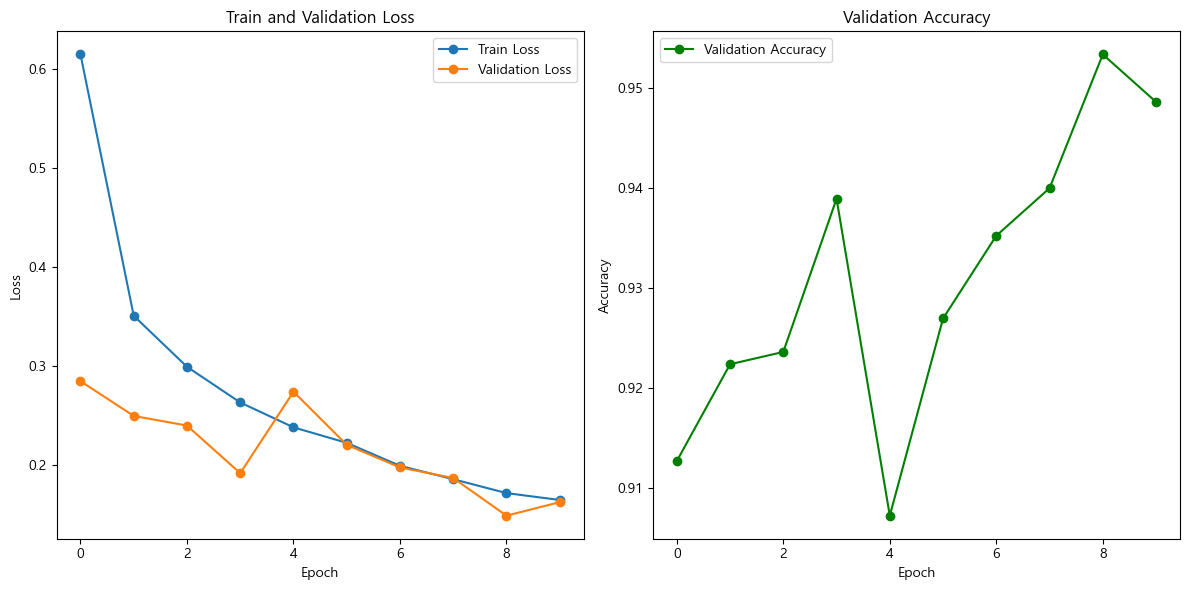

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()